In [1]:
import string
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, preprocessing
from sklearn.model_selection import train_test_split
import io
import matplotlib.pyplot as plt

from __future__ import print_function
from __future__ import division
import json
import numpy as np

from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Dropout, Flatten, Lambda, Embedding,LSTM
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.initializers import RandomNormal

from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import f1_score

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
from pathlib import Path

path = Path(os.getcwd())
path = path/'gdrive'/'My Drive'
news=path/'Thesis Data'/'full doc csv'
aa=path/'Thesis Data'/'Our dataset'
aa2=path/'Thesis Data'/'AA dataset'
char=path/'Thesis Data'/'char-ulm'
wiki_data = path/'Thesis Data'/'wiki_data'/'Wiki'

In [0]:
def load_ag_data(trainfile,testfile):
  
  onehotencoder = preprocessing.OneHotEncoder(categories='auto')

  ## TRAIN
  df = pd.read_csv(trainfile)
  df = df.dropna()
  df = df.sample(frac=1).reset_index(drop=True)#shuffle
  x_train = np.array(df['text']).reshape(-1,1)
  y_train = onehotencoder.fit_transform((df['label'].values).reshape(-1,1)).toarray()

  ## TEST
  df = pd.read_csv(testfile)
  df = df.dropna()
  df = df.sample(frac=1).reset_index(drop=True)#shuffle
  x_test = np.array(df['text']).reshape(-1,1)
  y_test = onehotencoder.transform((df['label'].values).reshape(-1,1)).toarray()

  return (x_train, y_train), (x_test, y_test)

In [0]:
def create_vocab_set():
    alphabet=" !\"#$%&'()*+,-./0123456789:;=<>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]^_`abcdefghijklmnopqrstuvwxyz{|}~¥§©±ঃঅআইঈউঊঋএঐওঔকখগঘঙচছজঝঞটঠডঢণতথদধনপফবভমযরলশষসহ়ািীুূৃেৈোৌ্ৎৗড়ঢ়য়০১২৩৪৫৬৭৮৯৷‘’‚“”‪™−√∝∞"    
    vocab_size = len(alphabet)
    print(vocab_size)
    vocab = {}
    reverse_vocab = {}
    for ix, t in enumerate(alphabet):
        vocab[t] = ix
        reverse_vocab[ix] = t
    return vocab, reverse_vocab, vocab_size, alphabet

In [0]:
def encode_data(x, maxlen, vocab):
    # Iterate over the loaded data and create a matrix of size (len(x), maxlen)
    # Each character is encoded into a one-hot array
    # Chars not in the vocab are encoded as -1, into an all zero vector.
    input_data = np.zeros((len(x), maxlen), dtype=np.int)
    for dix, sent in enumerate(x):
        counter = 0
        for c in sent[0]:
            if counter >= maxlen:
                pass
            else:
                ix = vocab.get(c, -1)  # get index from vocab dictionary, if not in vocab, return -1
                input_data[dix, counter] = ix
                counter += 1
    return input_data

## Model

In [0]:
def create_model(filter_kernels, dense_outputs, maxlen, vocab_size, nb_filter, cat_output, w):
    
    initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)

    # Define what the input shape looks like
    inputs = Input(shape=(maxlen,), dtype='int64')

    # print(w)
    embedded = Embedding(input_dim=vocab_size, output_dim=vocab_size , weights=[w])(inputs)

    # All the convolutional layers...
    conv = Convolution1D(filters=nb_filter[0], kernel_size=filter_kernels[0], kernel_initializer=initializer,
                         padding='valid', activation='relu',
                         input_shape=(maxlen, vocab_size))(embedded)
    conv = MaxPooling1D(pool_size=3)(conv)

    conv1 = Convolution1D(filters=nb_filter[1], kernel_size=filter_kernels[1], kernel_initializer=initializer,
                          padding='valid', activation='relu')(conv)
    conv1 = MaxPooling1D(pool_size=3)(conv1)

    conv2 = Convolution1D(filters=nb_filter[2], kernel_size=filter_kernels[2], kernel_initializer=initializer,
                          padding='valid', activation='relu')(conv1)
    conv2 = MaxPooling1D(pool_size=3)(conv2)

    conv3 = Convolution1D(filters=nb_filter[3], kernel_size=filter_kernels[3], kernel_initializer=initializer,
                          padding='valid', activation='relu')(conv2)
    conv3 = MaxPooling1D(pool_size=3)(conv3)
    conv3 = Flatten()(conv3)

    # Two dense layers with dropout of .5
    z = Dropout(0.5)(Dense(dense_outputs, activation='relu')(conv3))

    # Output dense layer with softmax activation
    pred = Dense(cat_output, activation='softmax', name='output')(z)

    model = Model(inputs=inputs, outputs=pred)

    sgd = SGD(lr=0.01, momentum=0.9)
    adam = Adam(lr=0.001, decay=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model


In [0]:
def CharCNN(trainfile,testfile,aa,cat_output,pre=False,w=0):
  np.random.seed(123)  # for reproducibility
  # Maximum length. Longer gets chopped. Shorter gets padded.
  maxlen = 3000
  # Model params
  # Filters for conv layers
  nb_filter = [64,128,256,256]
  # Number of units in the dense layer
  dense_outputs = 512
  # Conv layer kernel size
  filter_kernels = [7, 3,1,1]
  # Compile/fit params
  batch_size = 128
  nb_epoch = 15

  print('Loading data...')
  (xt, yt), (x_test, y_test) = load_ag_data(trainfile,testfile)

  print('Creating vocab...')
  vocab, reverse_vocab, vocab_size, alphabet = create_vocab_set()

  if not pre:
    w=np.eye(vocab_size)
  print('Build model...')
  model = create_model(filter_kernels, dense_outputs, maxlen, vocab_size,nb_filter, cat_output,w)
  
  print('Encode data...')
  xt = encode_data(xt, maxlen, vocab)
  x_test = encode_data(x_test, maxlen, vocab)
  print(xt[0])

  print('Chars vocab: {}'.format(alphabet))
  print('Chars vocab size: {}'.format(vocab_size))
  print('X_train.shape: {}'.format(xt.shape))
  model.summary()
  print('Fit model...')
  hist = model.fit(xt, yt, validation_split=0.2 , batch_size=batch_size, epochs=nb_epoch, shuffle=True)

  history = pd.DataFrame(hist.history)
  plt.figure(figsize=(12,12));
  plt.plot(history["loss"],label='loss');
  plt.plot(history["val_loss"], label='val-loss');
  plt.title("Loss with trained word vectors");
  plt.legend();
  # plt.show();
  plt.savefig(aa+'loss.eps')
  
  Y_pred = model.predict(x_test)
  y_pred = np.argmax(Y_pred, axis=1)
  y_test = np.argmax(y_test,axis=1)
  # print(y_pred)
  # print(y_test)
  acc = (y_test==y_pred).sum()/len(y_pred)
  f1 = f1_score(y_test, y_pred, average='macro')
  print("Accuracy=",acc," F1=",f1)
  cm=confusion_matrix(y_test, y_pred)
  print(cm)

  df_cm = pd.DataFrame(cm, range(cat_output),range(cat_output))
  plt.figure(figsize = (10,7))
  sn.set(font_scale=1.4)#for label size
  sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size
  plt.savefig(aa+'cm.eps')
  
  return model

## embedding warmup

Loading data...
Creating vocab...
181
Build model...


[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Encode data...
[100 117   0 ...   0   0   0]
Chars vocab:  !"#$%&'()*+,-./0123456789:;=<>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]^_`abcdefghijklmnopqrstuvwxyz{|}~¥§©±ঃঅআইঈউঊঋএঐওঔকখগঘঙচছজঝঞটঠডঢণতথদধনপফবভমযরলশষসহ়ািীুূৃেৈোৌ্ৎৗড়ঢ়য়০১২৩৪৫৬৭৮৯৷‘’‚“”‪™−√∝∞
Chars vocab size: 181
X_train.shape: (76718, 3000)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 3000, 181)         32761     
_______________________________

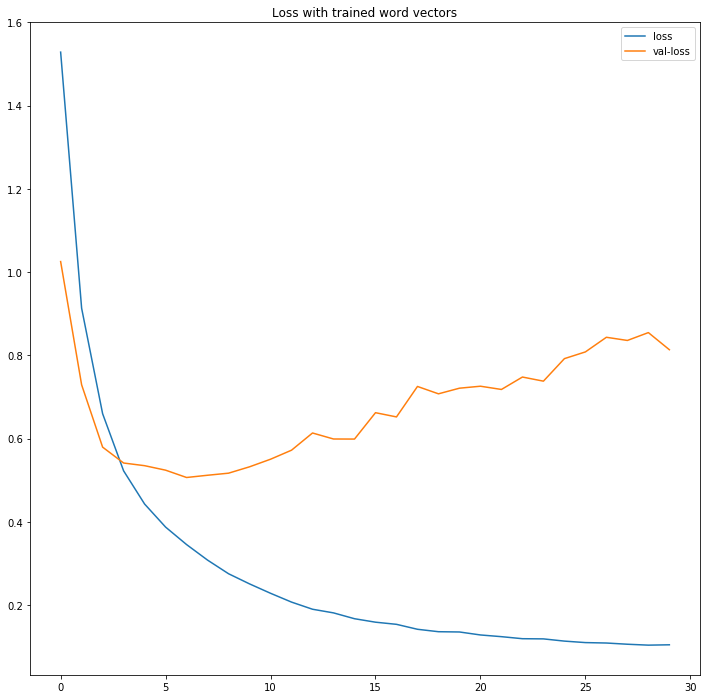

[2 9 5 ... 4 6 9]
[1 9 5 ... 4 6 8]
Accuracy= 0.8289700580028218  F1= 0.7984455127195417
[[1106    3   45    1    8   11   19   15    7   26    5   19]
 [   1  235   11    0    8  149   12    1   71   13    4   29]
 [  29    3 1417    6   30   13   25   15   12  160    9   10]
 [   0    0    4  551    1    3    6   16   28   66   13    1]
 [  13   17   17    5 1979   41   62    7   63  181    8   44]
 [  11  124   30    8   38 1630   13   31   21   58   18   44]
 [  10    8   15    7   50    9  580    5   34   98    8   10]
 [   9    0    7    8    8    8    5  897   27   25   10   16]
 [   2   19    6    5   34   28   19   19 1402   67    5   14]
 [  13    9   63   25  159   40   71   18  101 3479    3   38]
 [   5    6   25   23   14   17    9   14   17   12  428   12]
 [  13   18   16    2   39   47    9   15   18   35   10 2160]]


<Figure size 432x288 with 0 Axes>

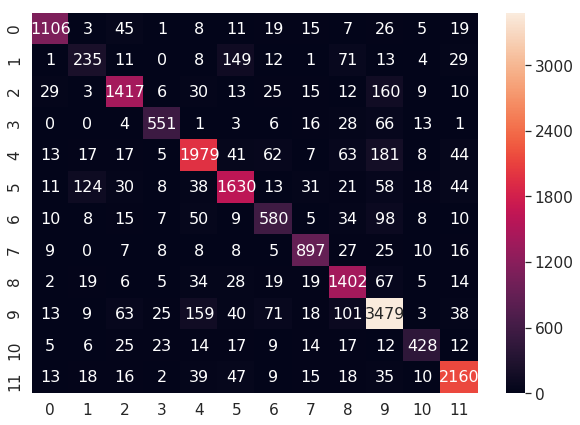

In [0]:
model = CharCNN(news/'full_doc_train.csv',news/'full_doc_test.csv','news',12)

### save w (embedding weights)

In [0]:
w = model.layers[1].get_weights()[0]
w = np.array([np.array(xi) for xi in w])
np.savetxt('embeds_alphanum.txt', w)
print(w)

[[ 1.1589820e+00  1.8467270e-02  1.6625153e-02 ...  3.6224626e-02
  -4.0239049e-04 -1.2708259e-03]
 [ 6.1910436e-02  1.3316355e+00  2.5669104e-01 ...  6.3110985e-02
  -1.0765278e-01  6.7953646e-02]
 [ 1.6314098e-01 -3.0627115e-02  1.3964207e+00 ...  3.3935286e-02
   1.0524376e-01 -9.7734377e-02]
 ...
 [-1.0469170e-02  1.1437356e-02  1.9513709e-02 ...  1.0050538e+00
   2.3384677e-02  4.3250397e-03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   1.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]]


In [22]:
w=np.loadtxt('embeds_alphanum.txt')
print(w)

[[ 1.15898204e+00  1.84672698e-02  1.66251529e-02 ...  3.62246260e-02
  -4.02390491e-04 -1.27082586e-03]
 [ 6.19104356e-02  1.33163548e+00  2.56691039e-01 ...  6.31109849e-02
  -1.07652783e-01  6.79536462e-02]
 [ 1.63140982e-01 -3.06271147e-02  1.39642072e+00 ...  3.39352861e-02
   1.05243757e-01 -9.77343768e-02]
 ...
 [-1.04691703e-02  1.14373555e-02  1.95137095e-02 ...  1.00505376e+00
   2.33846772e-02  4.32503968e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]


## AA2

Loading data...
Creating vocab...
181
Build model...
Encode data...
[129 144 117 ... 144 127 153]
Chars vocab:  !"#$%&'()*+,-./0123456789:;=<>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]^_`abcdefghijklmnopqrstuvwxyz{|}~¥§©±ঃঅআইঈউঊঋএঐওঔকখগঘঙচছজঝঞটঠডঢণতথদধনপফবভমযরলশষসহ়ািীুূৃেৈোৌ্ৎৗড়ঢ়য়০১২৩৪৫৬৭৮৯৷‘’‚“”‪™−√∝∞
Chars vocab size: 181
X_train.shape: (1800, 3000)
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3000)              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 3000, 181)         32761     
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 2994, 64)          81152     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 998, 64)           0         
______________________________________________

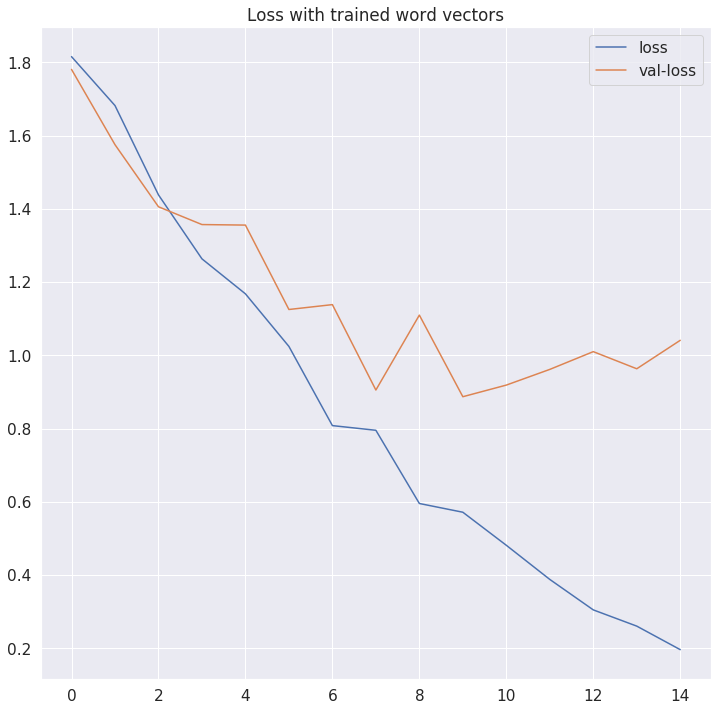

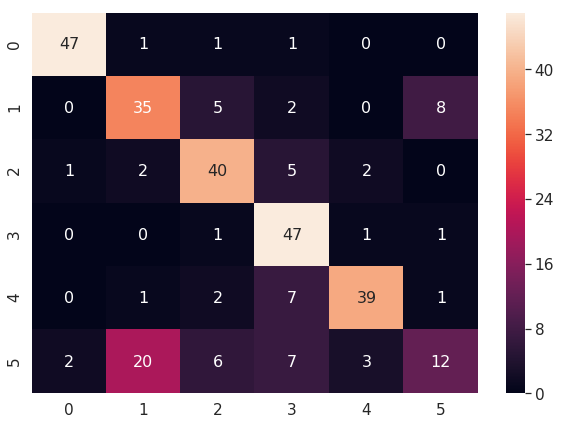

In [23]:
model = CharCNN(aa2/'ulm_train.csv',aa2/'ulm_test.csv','aa2',6,True,w)

## AA

Loading data...
Creating vocab...
181
Build model...
Encode data...
[141 101 158 ... 132 143 136]
Chars vocab:  !"#$%&'()*+,-./0123456789:;=<>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]^_`abcdefghijklmnopqrstuvwxyz{|}~¥§©±ঃঅআইঈউঊঋএঐওঔকখগঘঙচছজঝঞটঠডঢণতথদধনপফবভমযরলশষসহ়ািীুূৃেৈোৌ্ৎৗড়ঢ়য়০১২৩৪৫৬৭৮৯৷‘’‚“”‪™−√∝∞
Chars vocab size: 181
X_train.shape: (14374, 3000)
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3000)              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 3000, 181)         32761     
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 2994, 64)          81152     
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 998, 64)           0         
_____________________________________________

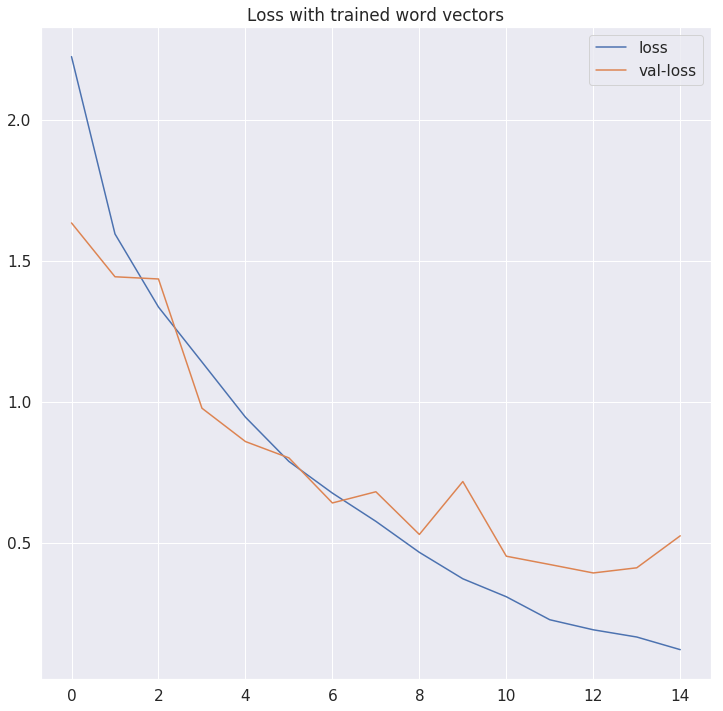

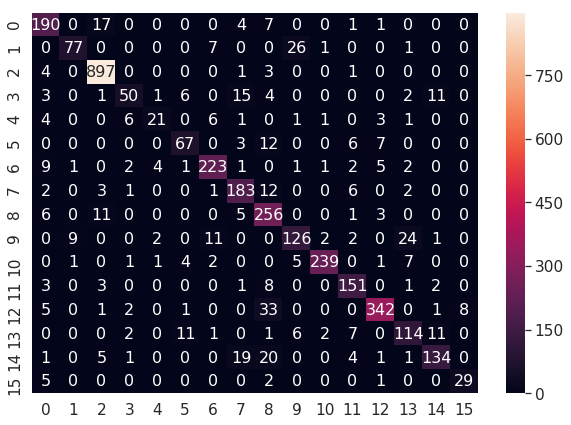

In [24]:
model = CharCNN(aa/'OurDataset_train.csv',aa/'OurDataset_test.csv','aa',16,True,w)